# ARIMA Model Fitting and Training

## Library

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
import itertools
from pmdarima import auto_arima
import statsmodels.api as sm

from col_eda import close_d_org, close_d, close_w, close_m

### Check data stationary

In [8]:
# From decomposition, we can see that the data has positive trend and seasonality. it is not stationary. 
def check_stationary(df):
    result = adfuller(df.diff().dropna())
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    print(result)
    
    # Decision based on p-value
    if p_value < 0.05:
        print(f"The p-value {p_value} is less than 0.05. We reject the null hypothesis. The time series is likely stationary.")
    else:
        print(f"The p-value {p_value} is greater than 0.05. We fail to reject the null hypothesis. The time series is likely non-stationary.")

    # Additional decision logic based on ADF statistic and critical values
    print("Based on the ADF Statistic and critical values:")
    if adf_statistic < critical_values['1%']:
        print("- The series is stationary with 99% confidence.")
    elif adf_statistic < critical_values['5%']:
        print("- The series is stationary with 95% confidence.")
    elif adf_statistic < critical_values['10%']:
        print("- The series is stationary with 90% confidence.")
    else:
        print("- The series is not stationary.")
        

In [9]:
print('close_d_org')
check_stationary(close_d_org)
print('\nclose_d')
check_stationary(close_d)
print('\nclose_w')
check_stationary(close_w)
print('\nclose_m')
check_stationary(close_m)

close_d_org
(-10.545115383241619, 8.452430710497291e-19, 11, 1300, {'1%': -3.435390199468821, '5%': -2.8637658312426035, '10%': -2.567955046745562}, -308.9021316688486)
The p-value 8.452430710497291e-19 is less than 0.05. We reject the null hypothesis. The time series is likely stationary.
Based on the ADF Statistic and critical values:
- The series is stationary with 99% confidence.

close_d
(-9.55196795524411, 2.5575963535382577e-16, 19, 1877, {'1%': -3.433838687021998, '5%': -2.863081058653235, '10%': -2.567590403056488}, -1147.040980613176)
The p-value 2.5575963535382577e-16 is less than 0.05. We reject the null hypothesis. The time series is likely stationary.
Based on the ADF Statistic and critical values:
- The series is stationary with 99% confidence.

close_w
(-17.32057784511083, 5.4846317951647954e-30, 0, 270, {'1%': -3.4548039258751206, '5%': -2.872304928618605, '10%': -2.5725063100137175}, 319.06585015923247)
The p-value 5.4846317951647954e-30 is less than 0.05. We reject t

In [42]:
# split train test set

In [10]:
def train_test(df, date):
    test_start_date = date
    train = df[:test_start_date]
    test = df[test_start_date:]
    return train, test

In [11]:
train, test = train_test(close_d, '2023-07-31')
train.shape

(1714, 1)

In [12]:
model = auto_arima(train, seasonal=True, random_state=42)
result = model.fit(train)
predictions = model.predict(n_periods=len(test))
# Summarize the best model
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1714
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 469.512
Date:                Tue, 05 Mar 2024   AIC                           -937.023
Time:                        20:25:07   BIC                           -931.577
Sample:                    11-21-2018   HQIC                          -935.008
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0338      0.000     76.034      0.000       0.033       0.035
Ljung-Box (L1) (Q):                   2.66   Jarque-Bera (JB):              9637.23
Prob(Q):                              0.10   Pr

In [65]:
def predictions_plot(df, test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label='Actual', color='blue')
    plt.plot(test.index, predictions, label='Predicted', color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

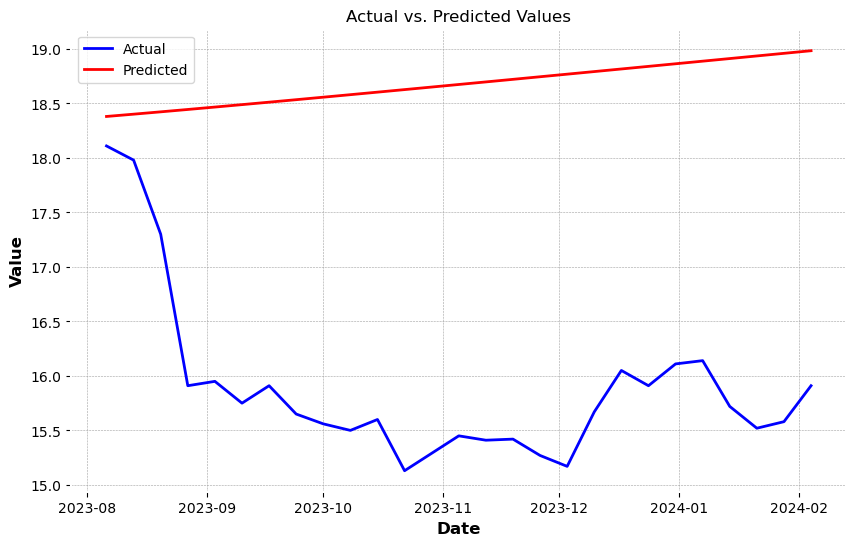

In [66]:
predictions_plot(train, test, predictions)

In [69]:
# Grid search to find the best parameters for SARIMA model
p = range(0, 3)  # Example: considering 0, 1, 2
d = range(0, 3)  # Example: considering 0, 1, 2
q = range(0, 3)  # Example: considering 0, 1, 2

P = range(0, 3)
D = range(0, 3)
Q = range(0, 3)
S = [30]

param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

best_aic = np.inf
best_params = None

for params in param_combinations:
    try:
        sm = SARIMAX(train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        results = sm.fit(disp=False)
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

if best_params is not None:
    final_model = sm.tsa.SARIMAX(train, order=(best_params[0], best_params[1], best_params[2]),
                                  seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal_period))
    final_results = final_model.fit()

    # Print the summary of the final model
    print(final_results.summary())
else:
    print("No suitable model found during grid search.")

No suitable model found during grid search.


In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Example for a seasonal time series
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fit_model = model.fit()
predictions = fit_model.forecast(len(test))

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 2.5779764042791466
Mean Squared Error (MSE): 7.424639210690931
Root Mean Squared Error (RMSE): 2.724819115224152
Mean Absolute Percentage Error (MAPE): nan%


In [59]:
from arch import arch_model
import pandas as pd

# Assuming 'returns' is a Pandas Series of financial returns
model = arch_model(close_d.pct_change().dropna(), p=1, q=1) # Specify GARCH(1, 1) model
res = model.fit(disp='off') # Fit the model
print(res.summary()) # Print the model summary

# Forecasting
forecasts = res.forecast(horizon=5) # Forecast the next 5 periods
print(forecasts.variance[-1:]) # Print the forecasted variances

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6002.03
Distribution:                  Normal   AIC:                          -11996.1
Method:            Maximum Likelihood   BIC:                          -11973.9
                                        No. Observations:                 1897
Date:                Tue, Mar 05 2024   Df Residuals:                     1896
Time:                        11:00:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.2188e-04  2.209e-04      1.457      0.145 

In [60]:
latest_price = train.iloc[-1]

# Convert forecasted returns to prices
predictions = [latest_price]

for ret in forecasts:
    predictions.append(predictions[-1] * (1 + ret))

predictions = predictions[1:]  # Remove the initial price used for calculation

print("Forecasted Prices:", predictions)

TypeError: 'ARCHModelForecast' object is not iterable